<a href="https://colab.research.google.com/github/Ricardo-Jaramillo/Python-Tensorflow/blob/main/04_transfer_learning_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 1: Feature extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

Tue Aug 22 22:59:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-08-22 22:59:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 142.250.99.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   206MB/s    in 0.8s    

2023-08-22 22:59:40 (206 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "10_food_classes_10_percent".
There are 10 directories and 0 images in "10_food_classes_10_percent/test".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/hamburger".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/fried_rice".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ramen".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_curry".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_wings".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/steak".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ice_cream".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/pizza".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/sushi".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/gri

## Creating data loaders (preparing the data)
We'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoeard clalback  (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_slasses output neurons.
  '''
  # Download the pretrained model and save it as a Keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # freeze the already learned patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model



### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')]
                                  )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/Y0822-225958
Epoch 1/5
24/24 [==============================] - 27s 595ms/step - loss: 1.7639 - accuracy: 0.4013 - val_loss: 1.1107 - val_accuracy: 0.6504
Epoch 2/5
24/24 [==============================] - 13s 542ms/step - loss: 0.8473 - accuracy: 0.7533 - val_loss: 0.8470 - val_accuracy: 0.7180
Epoch 3/5
24/24 [==============================] - 11s 483ms/step - loss: 0.5931 - accuracy: 0.8333 - val_loss: 0.7316 - val_accuracy: 0.7688
Epoch 4/5
24/24 [==============================] - 13s 558ms/step - loss: 0.4582 - accuracy: 0.8853 - val_loss: 0.6999 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 11s 481ms/step - loss: 0.3681 - accuracy: 0.9200 - val_loss: 0.6745 - val_accuracy: 0.7824


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns;
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

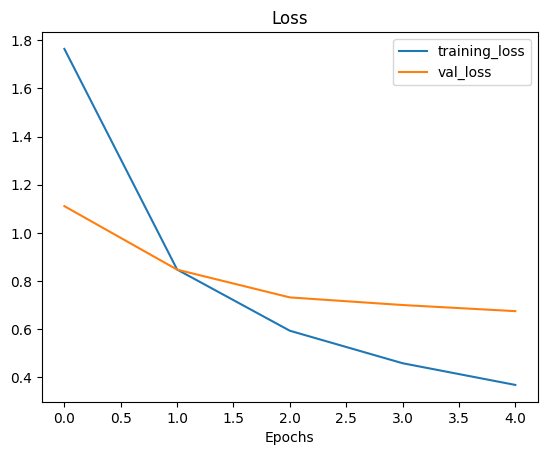

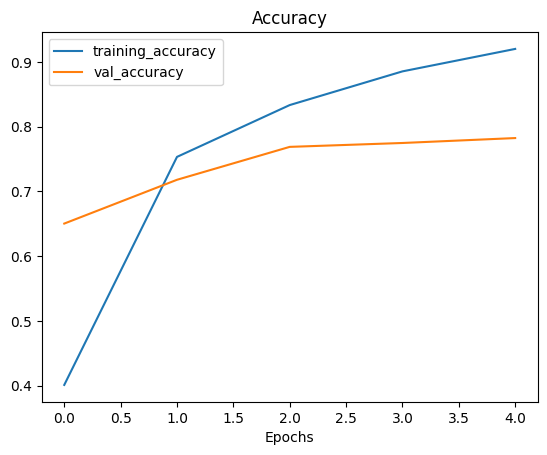

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficienNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')]
                                              )

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/Y0822-230143
Epoch 1/5
24/24 [==============================] - 23s 519ms/step - loss: 1.7629 - accuracy: 0.4907 - val_loss: 1.2633 - val_accuracy: 0.7476
Epoch 2/5
24/24 [==============================] - 10s 411ms/step - loss: 1.0396 - accuracy: 0.7867 - val_loss: 0.8534 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 9s 399ms/step - loss: 0.7425 - accuracy: 0.8427 - val_loss: 0.6883 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 12s 536ms/step - loss: 0.5946 - accuracy: 0.8680 - val_loss: 0.6027 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 12s 512ms/step - loss: 0.5016 - accuracy: 0.8867 - val_loss: 0.5515 - val_accuracy: 0.8608


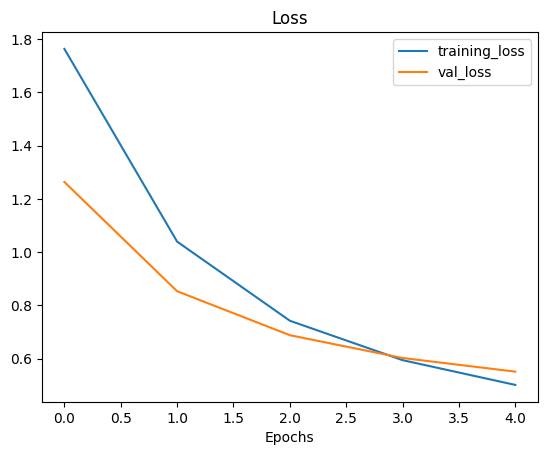

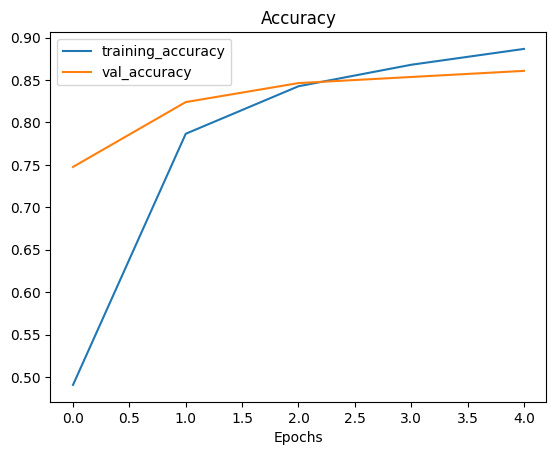

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the outputlayer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our model's results using TensorBoard

https://tensorboard.dev/#get-started

> **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB0 vs. ResNet50V2' \
  --description 'Comparing two different TF Hub feature extraction model architecures using 10% of the training data' \
  --one_shot

2023-08-22 23:09:14.124353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/0ax0SzYySwWzxsgSR56rvQ/

[2023-08-22T23:09:16] Started scanning logdir.
[2023-08-22T23:09:18] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.7 MB)
[2023-08-22T23:09:18] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/0ax0SzYySwWzxsgSR56rvQ/


Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/0ax0SzYySwWzxsgSR56rvQ/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2023-08-22 23:12:15.554552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/0ax0SzYySwWzxsgSR56rvQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecures using 10% of the training data
	Id                   0ax0SzYySwWzxsgSR56rvQ
	Created              2023-08-22 23:09:16 (3 minutes ago)
	Updated              2023-08-22 23:09:18 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5934984
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id 0ax0SzYySwWzxsgSR56rvQ

2023-08-22 23:13:11.707911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment 0ax0SzYySwWzxsgSR56rvQ.


In [ ]:
# Confirm the deletion by re.checking what experiments you have left
!tensorboard dev list

2023-08-22 23:13:40.804658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No experiments. Use `tensorboard dev upload` to get started.


## 🛠 Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
  * You can use any feature extraction layer from TensorFlow Hub you like for this.
  * You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?
  * Hint: you might want to check [sotabench.com](https://www.sotabench.com) for this.

## 📖 Extra-curriculum

* Read through the [TensorFlow Transfer Learning Guide](https://www.tensorflow.org/tutorials/images/transfer_learning) and define the main two types of transfer learning in your own words.
* Go through the [Transfer Learning with TensorFlow Hub tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) on the TensorFlow website and rewrite all of the code yourself into a new Google Colab notebook making comments about what each step does along the way.
* We haven't covered fine-tuning with TensorFlow Hub in this notebook, but if you'd like to know more, go through the [fine-tuning a TensorFlow Hub model tutorial](https://www.tensorflow.org/hub/tf2_saved_model#fine-tuning) on the TensorFlow homepage.How to fine-tune a tensorflow hub model:  
* Look into [experiment tracking with Weights & Biases](https://www.wandb.com/experiment-tracking), how could you integrate it with our existing TensorBoard logs?